<a href="https://colab.research.google.com/github/seiji0203/LSTM_-/blob/master/LSTM_Z%E3%83%9B%E3%83%BC%E3%83%AB%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%82%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [339]:
# モジュールのインポート
import numpy as np
import pandas as pd
import pandas_datareader.data as data
from matplotlib import pyplot as plt
%matplotlib inline

# 週を追加
from datetime import datetime
from datetime import timedelta

# 標準化関数（StandardScaler）をインポート
from sklearn.preprocessing import StandardScaler

# LSTM
!pip install tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

# 時系列分割のためTimeSeriesSplitのインポート
from sklearn.model_selection import TimeSeriesSplit
# accuracy算出のためためaccuracy_scoreのインポート
from sklearn.metrics import accuracy_score

# 混同行列生成のための混同行列生成のためのconfusion_matrixをインポート
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [340]:
start = '2005-01-01'
end = '2022-01-01'

df = data.DataReader('4689.JP', 'stooq', start, end) 
df.to_csv('Z_Holdings.csv')

In [341]:
# データの確認
df = pd.read_csv('Z_Holdings.csv')
df

,Date,Open,High,Low,Close,Volume
0,2021-12-30,646.90,677.00,645.70,667.40,21235600
1,2021-12-29,644.00,649.60,641.90,645.90,7257200
2,2021-12-28,649.20,654.60,643.60,644.00,12849300
3,2021-12-27,656.00,659.50,638.30,640.20,16486400
4,2021-12-24,663.10,690.10,661.70,663.40,18055500
...,...,...,...,...,...,...
4103,2005-03-28,586.38,588.58,557.61,570.88,18962973
4104,2005-03-25,577.54,583.05,573.09,580.85,37678290
4105,2005-03-24,570.88,571.98,566.47,568.68,15077282
4106,2005-03-23,568.68,573.09,565.36,569.77,15162243


In [342]:
# カラムのデータ型の確認、欠損値の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4108 entries, 0 to 4107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4108 non-null   object 
 1   Open    4108 non-null   float64
 2   High    4108 non-null   float64
 3   Low     4108 non-null   float64
 4   Close   4108 non-null   float64
 5   Volume  4108 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 192.7+ KB


In [343]:
# Dateデータがobject型なので、datatime64型へ変更（利便性が高いため）
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4108 entries, 0 to 4107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4108 non-null   datetime64[ns]
 1   Open    4108 non-null   float64       
 2   High    4108 non-null   float64       
 3   Low     4108 non-null   float64       
 4   Close   4108 non-null   float64       
 5   Volume  4108 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 192.7 KB


In [344]:
# 曜日情報の追加（月曜日:0, 火曜日:1, 水曜日:2, 木曜日:3, 金曜日:4, 土曜日:5, 日曜日:6）
df['weekday'] = df['Date'].dt.weekday
df

,Date,Open,High,Low,Close,Volume,weekday
0,2021-12-30,646.90,677.00,645.70,667.40,21235600,3
1,2021-12-29,644.00,649.60,641.90,645.90,7257200,2
2,2021-12-28,649.20,654.60,643.60,644.00,12849300,1
3,2021-12-27,656.00,659.50,638.30,640.20,16486400,0
4,2021-12-24,663.10,690.10,661.70,663.40,18055500,4
...,...,...,...,...,...,...,...
4103,2005-03-28,586.38,588.58,557.61,570.88,18962973,0
4104,2005-03-25,577.54,583.05,573.09,580.85,37678290,4
4105,2005-03-24,570.88,571.98,566.47,568.68,15077282,3
4106,2005-03-23,568.68,573.09,565.36,569.77,15162243,2


In [345]:
# 初めの月曜日として3/21を基準に週を追加
start = datetime(2005,3,21)
df['weeks'] = (df['Date'] - start) // timedelta(weeks=1) # Dateから1965/1/4を引いた値を週の数で割り算した商を求めています
df

,Date,Open,High,Low,Close,Volume,weekday,weeks
0,2021-12-30,646.90,677.00,645.70,667.40,21235600,3,875
1,2021-12-29,644.00,649.60,641.90,645.90,7257200,2,875
2,2021-12-28,649.20,654.60,643.60,644.00,12849300,1,875
3,2021-12-27,656.00,659.50,638.30,640.20,16486400,0,875
4,2021-12-24,663.10,690.10,661.70,663.40,18055500,4,874
...,...,...,...,...,...,...,...,...
4103,2005-03-28,586.38,588.58,557.61,570.88,18962973,0,1
4104,2005-03-25,577.54,583.05,573.09,580.85,37678290,4,0
4105,2005-03-24,570.88,571.98,566.47,568.68,15077282,3,0
4106,2005-03-23,568.68,573.09,565.36,569.77,15162243,2,0


In [346]:
# 理解しやすいようにカラムの並び替えを行います。
df = df[['Date', 'weeks', 'weekday', 'High', 'Low', 'Open', 'Close']]
df

,Date,weeks,weekday,High,Low,Open,Close
0,2021-12-30,875,3,677.00,645.70,646.90,667.40
1,2021-12-29,875,2,649.60,641.90,644.00,645.90
2,2021-12-28,875,1,654.60,643.60,649.20,644.00
3,2021-12-27,875,0,659.50,638.30,656.00,640.20
4,2021-12-24,874,4,690.10,661.70,663.10,663.40
...,...,...,...,...,...,...,...
4103,2005-03-28,1,0,588.58,557.61,586.38,570.88
4104,2005-03-25,0,4,583.05,573.09,577.54,580.85
4105,2005-03-24,0,3,571.98,566.47,570.88,568.68
4106,2005-03-23,0,2,573.09,565.36,568.68,569.77


In [347]:
# データの並び替え（sort_valuesで日付順に並び替えを行う）
df.sort_values(by='Date', ascending=True, inplace=True)

# 日付のDateをインデックスにセット（今回のような時系列データを処理する際はset_indexを使用して日付をインデックスに設定）
df.set_index(keys="Date", inplace=True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-03-22,0,1,575.31,566.47,567.57,567.57
2005-03-23,0,2,573.09,565.36,568.68,569.77
2005-03-24,0,3,571.98,566.47,570.88,568.68
2005-03-25,0,4,583.05,573.09,577.54,580.85
2005-03-28,1,0,588.58,557.61,586.38,570.88
...,...,...,...,...,...,...
2021-12-24,874,4,690.10,661.70,663.10,663.40
2021-12-27,875,0,659.50,638.30,656.00,640.20
2021-12-28,875,1,654.60,643.60,649.20,644.00


In [348]:
# カラム情報を1行上にずらしたフレームワークを作成します。（カラムの情報を一行上に）
df_shift = df.shift(-1)
df_shift

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-03-22,0.0,2.0,573.09,565.36,568.68,569.77
2005-03-23,0.0,3.0,571.98,566.47,570.88,568.68
2005-03-24,0.0,4.0,583.05,573.09,577.54,580.85
2005-03-25,1.0,0.0,588.58,557.61,586.38,570.88
2005-03-28,1.0,1.0,570.88,550.96,568.68,557.61
...,...,...,...,...,...,...
2021-12-24,875.0,0.0,659.50,638.30,656.00,640.20
2021-12-27,875.0,1.0,654.60,643.60,649.20,644.00
2021-12-28,875.0,2.0,649.60,641.90,644.00,645.90


In [349]:
# 翌日の終値と本日の終値の差分を追加する
df['delta_Close'] = df_shift['Close'] - df['Close']
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,weeks,weekday,High,Low,Open,Close,delta_Close
Date,,,,,,,
2005-03-22,0,1,575.31,566.47,567.57,567.57,2.20
2005-03-23,0,2,573.09,565.36,568.68,569.77,-1.09
2005-03-24,0,3,571.98,566.47,570.88,568.68,12.17
2005-03-25,0,4,583.05,573.09,577.54,580.85,-9.97
2005-03-28,1,0,588.58,557.61,586.38,570.88,-13.27
...,...,...,...,...,...,...,...
2021-12-24,874,4,690.10,661.70,663.10,663.40,-23.20
2021-12-27,875,0,659.50,638.30,656.00,640.20,3.80
2021-12-28,875,1,654.60,643.60,649.20,644.00,1.90


In [350]:
#目的変数Upを追加する（翌日の始値が上がる場合1、それ以外は0とする）
df['Up'] = 0
df['Up'][df['delta_Close'] > 0] = 1 # delta_Closeが0以上なら1を、それ以外は0を返すカラムを追加します
df = df.drop('delta_Close', axis=1) # 必要ないので削除します
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-03-22,0,1,575.31,566.47,567.57,567.57,1
2005-03-23,0,2,573.09,565.36,568.68,569.77,0
2005-03-24,0,3,571.98,566.47,570.88,568.68,1
2005-03-25,0,4,583.05,573.09,577.54,580.85,0
2005-03-28,1,0,588.58,557.61,586.38,570.88,0
...,...,...,...,...,...,...,...
2021-12-24,874,4,690.10,661.70,663.10,663.40,0
2021-12-27,875,0,659.50,638.30,656.00,640.20,1
2021-12-28,875,1,654.60,643.60,649.20,644.00,1


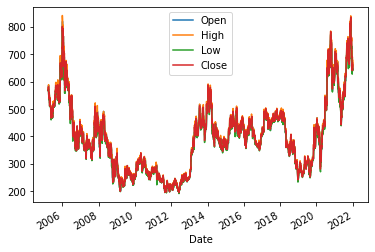

In [351]:
# High, Low, Open, Closeをグラフ化するためにカラム抽出を行う
df_new = df[['Open', 'High', 'Low', 'Close']]
#時系列の折れ線グラフを作成
df_new.plot(kind='line')

In [352]:
#終値の前日比率（本日の終値が前日の初値から何％変化したかを表す値 :（今日の終値 - 前日の終値）/前日の終値）
df_shift = df.shift(1)

df['Close_ratio'] = df['Close'] - df_shift['Close'] / df_shift['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio
Date,,,,,,,,
2005-03-22,0,1,575.31,566.47,567.57,567.57,1,NaN
2005-03-23,0,2,573.09,565.36,568.68,569.77,0,568.77
2005-03-24,0,3,571.98,566.47,570.88,568.68,1,567.68
2005-03-25,0,4,583.05,573.09,577.54,580.85,0,579.85
2005-03-28,1,0,588.58,557.61,586.38,570.88,0,569.88
...,...,...,...,...,...,...,...,...
2021-12-24,874,4,690.10,661.70,663.10,663.40,0,662.40
2021-12-27,875,0,659.50,638.30,656.00,640.20,1,639.20
2021-12-28,875,1,654.60,643.60,649.20,644.00,1,643.00


In [353]:
#始値・終値の差分
df['Body'] = df['Open'] - df['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body
Date,,,,,,,,,
2005-03-22,0,1,575.31,566.47,567.57,567.57,1,NaN,0.00
2005-03-23,0,2,573.09,565.36,568.68,569.77,0,568.77,-1.09
2005-03-24,0,3,571.98,566.47,570.88,568.68,1,567.68,2.20
2005-03-25,0,4,583.05,573.09,577.54,580.85,0,579.85,-3.31
2005-03-28,1,0,588.58,557.61,586.38,570.88,0,569.88,15.50
...,...,...,...,...,...,...,...,...,...
2021-12-24,874,4,690.10,661.70,663.10,663.40,0,662.40,-0.30
2021-12-27,875,0,659.50,638.30,656.00,640.20,1,639.20,15.80
2021-12-28,875,1,654.60,643.60,649.20,644.00,1,643.00,5.20


やりたいこと
月曜日から木曜日までの情報をもとに、金曜日の初まり値が上がるか下がるかの予測モデルの作成

In [354]:
# 週番号をリストに格納
list_weeks = []
list_weeks = df['weeks'].unique()
list_weeks

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [355]:
# 各週ごとの日数を入力
df['week_days'] = 0
for i in list_weeks:
    df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])
    
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.p

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-03-22,0,1,575.31,566.47,567.57,567.57,1,NaN,0.00,4
2005-03-23,0,2,573.09,565.36,568.68,569.77,0,568.77,-1.09,4
2005-03-24,0,3,571.98,566.47,570.88,568.68,1,567.68,2.20,4
2005-03-25,0,4,583.05,573.09,577.54,580.85,0,579.85,-3.31,4
2005-03-28,1,0,588.58,557.61,586.38,570.88,0,569.88,15.50,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-24,874,4,690.10,661.70,663.10,663.40,0,662.40,-0.30,5
2021-12-27,875,0,659.50,638.30,656.00,640.20,1,639.20,15.80,4
2021-12-28,875,1,654.60,643.60,649.20,644.00,1,643.00,5.20,4


In [356]:
#　月曜日〜金曜日まで5日分データがある週だけデータを取り出します
df = df[df['week_days'] == 5]
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-03-28,1,0,588.58,557.61,586.38,570.88,0,569.88,15.50,5
2005-03-29,1,1,570.88,550.96,568.68,557.61,0,556.61,11.07,5
2005-03-30,1,2,564.24,546.54,555.40,553.18,1,552.18,2.22,5
2005-03-31,1,3,562.03,550.96,557.61,555.40,0,554.40,2.21,5
2005-04-01,1,4,550.96,544.34,546.54,548.76,0,547.76,-2.22,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-20,874,0,669.00,642.20,664.00,642.20,0,641.20,21.80,5
2021-12-21,874,1,652.20,627.10,651.60,641.40,1,640.40,10.20,5
2021-12-22,874,2,663.80,647.30,653.50,659.00,0,658.00,-5.50,5


In [357]:
# 金曜日（4）を予測したいので、4のカラムの削除をします
df = df[df['weekday'] != 4]
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-03-28,1,0,588.58,557.61,586.38,570.88,0,569.88,15.50,5
2005-03-29,1,1,570.88,550.96,568.68,557.61,0,556.61,11.07,5
2005-03-30,1,2,564.24,546.54,555.40,553.18,1,552.18,2.22,5
2005-03-31,1,3,562.03,550.96,557.61,555.40,0,554.40,2.21,5
2005-04-04,2,0,550.96,533.26,550.96,539.91,0,538.91,11.05,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-16,873,3,713.20,689.60,703.00,691.00,0,690.00,12.00,5
2021-12-20,874,0,669.00,642.20,664.00,642.20,0,641.20,21.80,5
2021-12-21,874,1,652.20,627.10,651.60,641.40,1,640.40,10.20,5


In [358]:
# 不要カラムの削除と並び替え
df = df[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body', 'Up']]
df

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2005-03-28,0,588.58,557.61,586.38,570.88,569.88,15.50,0
2005-03-29,1,570.88,550.96,568.68,557.61,556.61,11.07,0
2005-03-30,2,564.24,546.54,555.40,553.18,552.18,2.22,1
2005-03-31,3,562.03,550.96,557.61,555.40,554.40,2.21,0
2005-04-04,0,550.96,533.26,550.96,539.91,538.91,11.05,0
...,...,...,...,...,...,...,...,...
2021-12-16,3,713.20,689.60,703.00,691.00,690.00,12.00,0
2021-12-20,0,669.00,642.20,664.00,642.20,641.20,21.80,0
2021-12-21,1,652.20,627.10,651.60,641.40,640.40,10.20,1


In [359]:
# 学習データ（2018~2020）をdf_trainに入力
df_train = df['2006-01-01' : '2020-12-31']
df_train

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2006-01-16,0,805.43,765.62,783.31,792.15,791.15,-8.84,0
2006-01-17,1,778.89,716.93,765.62,725.77,724.77,39.85,0
2006-01-18,2,677.10,606.28,659.39,654.97,653.97,4.42,1
2006-01-19,3,743.49,681.53,685.95,743.49,742.49,-57.54,0
2006-01-23,0,690.37,659.39,663.82,668.25,667.25,-4.43,1
...,...,...,...,...,...,...,...,...
2020-12-17,3,611.41,598.54,606.86,608.94,607.94,-2.08,0
2020-12-21,0,613.00,600.32,606.86,604.48,603.48,2.38,0
2020-12-22,1,597.65,587.15,596.76,594.58,593.58,2.18,1


In [360]:
# 検証データ(2021)に分割
df_val = df['2021-01-01' : ]
df_val

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2021-01-04,0,636.36,618.54,624.28,630.52,629.52,-6.24,1
2021-01-05,1,660.03,630.42,633.69,652.60,651.60,-18.91,1
2021-01-06,2,693.30,652.60,653.00,683.20,682.20,-30.20,0
2021-01-07,3,691.81,666.36,680.03,672.90,671.90,7.13,1
2021-01-18,0,698.84,676.36,695.97,693.10,692.10,2.87,1
...,...,...,...,...,...,...,...,...
2021-12-16,3,713.20,689.60,703.00,691.00,690.00,12.00,0
2021-12-20,0,669.00,642.20,664.00,642.20,641.20,21.80,0
2021-12-21,1,652.20,627.10,651.60,641.40,640.40,10.20,1


In [361]:
# 学習データを説明変数（X_train）と目的変数（y_train）に分ける
X_train = df_train[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
y_train = df_train['Up']

#学習データの説明変数と目的変数を確認
print(X_train)
print(y_train)

            weekday    High     Low    Open   Close  Close_ratio   Body
Date                                                                   
2006-01-16        0  805.43  765.62  783.31  792.15       791.15  -8.84
2006-01-17        1  778.89  716.93  765.62  725.77       724.77  39.85
2006-01-18        2  677.10  606.28  659.39  654.97       653.97   4.42
2006-01-19        3  743.49  681.53  685.95  743.49       742.49 -57.54
2006-01-23        0  690.37  659.39  663.82  668.25       667.25  -4.43
...             ...     ...     ...     ...     ...          ...    ...
2020-12-17        3  611.41  598.54  606.86  608.94       607.94  -2.08
2020-12-21        0  613.00  600.32  606.86  604.48       603.48   2.38
2020-12-22        1  597.65  587.15  596.76  594.58       593.58   2.18
2020-12-23        2  607.25  586.36  592.80  607.15       606.15 -14.35
2020-12-24        3  608.44  597.35  603.19  602.90       601.90   0.29

[2424 rows x 7 columns]
Date
2006-01-16    0
2006-01-17    0
20

In [362]:
# 学習データを説明変数（X_train）と目的変数（y_train）に分ける
X_val = df_val[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
y_val = df_val['Up']

#学習データの説明変数と目的変数を確認
print(X_val)
print(y_val)

            weekday    High     Low    Open   Close  Close_ratio   Body
Date                                                                   
2021-01-04        0  636.36  618.54  624.28  630.52       629.52  -6.24
2021-01-05        1  660.03  630.42  633.69  652.60       651.60 -18.91
2021-01-06        2  693.30  652.60  653.00  683.20       682.20 -30.20
2021-01-07        3  691.81  666.36  680.03  672.90       671.90   7.13
2021-01-18        0  698.84  676.36  695.97  693.10       692.10   2.87
...             ...     ...     ...     ...     ...          ...    ...
2021-12-16        3  713.20  689.60  703.00  691.00       690.00  12.00
2021-12-20        0  669.00  642.20  664.00  642.20       641.20  21.80
2021-12-21        1  652.20  627.10  651.60  641.40       640.40  10.20
2021-12-22        2  663.80  647.30  653.50  659.00       658.00  -5.50
2021-12-23        3  661.40  649.30  655.20  654.90       653.90   0.30

[164 rows x 7 columns]
Date
2021-01-04    1
2021-01-05    1
202

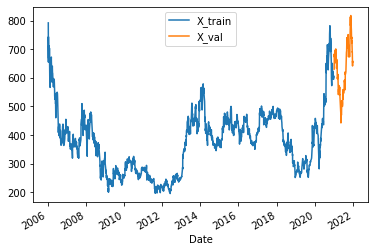

<Figure size 1440x1080 with 0 Axes>

In [363]:
# 学習データと検証データの終値（Close）の折れ線グラフ作成
X_train['Close'].plot(kind='line')
X_val['Close'].plot(kind='line')

# グラフの凡例を設定
plt.legend(['X_train', 'X_val'])

# グラフ表示
plt.figure(figsize=(20,15))
plt.show()

In [364]:
# 4日ごとにデータを抜き出して、標準化とNumpy配列に変換する関数（SS_to_np）の定義
def SS_to_np(df):
    df_list = []
    df = np.array(df) # 入力されたdfをnumpy配列に変換する
    for i in range(0, len(df) -3, 4): # 最後の4日分のデータまで以下の処理を繰り返す
        df_s = df[i:i+4] # 4日ずつのデータを抜き出してdf_sに入力する
        SS = StandardScaler() # SSとしてインスタンス化する
        df_SS = SS.fit_transform(df_s) # 標準化した結果を格納
        df_list.append(df_SS) # 標準化をおこなった結果をappendで追加
    return np.array(df_list) # 最後の処理が終了したらdf_listをnumpy配列で出力する

In [365]:
# 学習データと検証データの説明変数に変換（SS_to_np）を実行
X_train_np_array = SS_to_np(X_train)
X_val_np_array = SS_to_np(X_val)

# 学習データと検証データのデータの形を確認
print(X_train_np_array.shape) # 480日分のrowsが120に
print(X_val_np_array.shape) # 132日分あったrowsが33に

(606, 4, 7)
(41, 4, 7)


In [366]:
# 学習データと検証データの目的変数を確認
print(X_train)
print(X_val)

            weekday    High     Low    Open   Close  Close_ratio   Body
Date                                                                   
2006-01-16        0  805.43  765.62  783.31  792.15       791.15  -8.84
2006-01-17        1  778.89  716.93  765.62  725.77       724.77  39.85
2006-01-18        2  677.10  606.28  659.39  654.97       653.97   4.42
2006-01-19        3  743.49  681.53  685.95  743.49       742.49 -57.54
2006-01-23        0  690.37  659.39  663.82  668.25       667.25  -4.43
...             ...     ...     ...     ...     ...          ...    ...
2020-12-17        3  611.41  598.54  606.86  608.94       607.94  -2.08
2020-12-21        0  613.00  600.32  606.86  604.48       603.48   2.38
2020-12-22        1  597.65  587.15  596.76  594.58       593.58   2.18
2020-12-23        2  607.25  586.36  592.80  607.15       606.15 -14.35
2020-12-24        3  608.44  597.35  603.19  602.90       601.90   0.29

[2424 rows x 7 columns]
            weekday    High     Low    

In [367]:
# 学習データ、検証データの目的変数の間引き・週の4日目（木曜日）のデータだけ抜き出す
y_train_new = y_train[3::4]
y_val_new = y_val[3::4]

# 間引き後の学習データと検証データ
print(len(y_train_new))
print(len(y_val_new))

606
41


In [368]:
# LSTM構築とコンパイル関数
def lstm_comp(df):
  # 入力層/中間層/出力層のネットワーク構築
  model = Sequential()
  model.add(LSTM(256, activation='relu', batch_input_shape=(None, df.shape[1], df.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  # ネットワークのコンパイル
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
  return model

In [369]:
# 時系列分割交差検証
valid_scores = [] # 4回分の交差検証の結果を代入する空のリストを作成
tscv = TimeSeriesSplit(n_splits=4) # TimeSeriesSplitのインスタンス化を行い変数に代入する

# for文で交差検証を4回行う、、splitメソッドを用いて学習データを分割して交差検証用の学習データと検証データを作成する
for fold, (train_indices, valid_indices) in enumerate(tscv.split(X_train_np_array)):
    X_train, X_valid = X_train_np_array[train_indices], X_train_np_array[valid_indices]
    y_train, y_valid = y_train_new[train_indices], y_train_new[valid_indices]

    # LSTM構築とコンパイル関数にX_trainを渡し、変数変数modelに代入
    model = lstm_comp(X_train)

    # モデル学習
    model.fit(X_train, y_train, epochs=10, batch_size=64)

    # 予測
    y_valid_pred = model.predict(X_valid)

    # 予測結果の予測結果の2値化
    y_valid_pred = np.where(y_valid_pred < 0.5, 0, 1)

    # 予測精度の算出と表示
    score = accuracy_score(y_valid, y_valid_pred)
    print(f'fold {fold} MAE: {score}')

    # 予測精度のスコアをリストに格納
    valid_scores.append(score)

print(f'valid_scores: {valid_scores}')
cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

Epoch 1/10
2/2 [==============================] - 3s 61ms/step - loss: 0.6907 - accuracy: 0.5164
Epoch 2/10
2/2 [==============================] - 0s 64ms/step - loss: 0.6789 - accuracy: 0.5984
Epoch 3/10
2/2 [==============================] - 0s 36ms/step - loss: 0.6724 - accuracy: 0.5984
Epoch 4/10
2/2 [==============================] - 0s 48ms/step - loss: 0.6724 - accuracy: 0.5984
Epoch 5/10
2/2 [==============================] - 0s 35ms/step - loss: 0.6642 - accuracy: 0.5984
Epoch 6/10
2/2 [==============================] - 0s 32ms/step - loss: 0.6688 - accuracy: 0.5984
Epoch 7/10
2/2 [==============================] - 0s 63ms/step - loss: 0.6695 - accuracy: 0.5984
Epoch 8/10
2/2 [==============================] - 0s 47ms/step - loss: 0.6661 - accuracy: 0.5984
Epoch 9/10
2/2 [==============================] - 0s 42ms/step - loss: 0.6677 - accuracy: 0.5984
Epoch 10/10
2/2 [==============================] - 0s 36ms/step - loss: 0.6608 - accuracy: 0.5984
fold 0 MAE: 0.528925619834710

In [370]:
# LSTM構築とコンパイル関数にX_train_np_arrayを渡し、変数変数modelに代入
model = lstm_comp(X_train_np_array)

In [371]:
# モデルの学習の実行
result = model.fit(X_train_np_array, y_train_new, epochs=10, batch_size=64)

Epoch 1/10
10/10 [==============================] - 2s 23ms/step - loss: 0.6875 - accuracy: 0.5446
Epoch 2/10
10/10 [==============================] - 0s 24ms/step - loss: 0.6835 - accuracy: 0.5627
Epoch 3/10
10/10 [==============================] - 0s 26ms/step - loss: 0.6812 - accuracy: 0.5677
Epoch 4/10
10/10 [==============================] - 0s 24ms/step - loss: 0.6797 - accuracy: 0.5726
Epoch 5/10
10/10 [==============================] - 0s 23ms/step - loss: 0.6801 - accuracy: 0.5792
Epoch 6/10
10/10 [==============================] - 0s 24ms/step - loss: 0.6838 - accuracy: 0.5578
Epoch 7/10
10/10 [==============================] - 0s 22ms/step - loss: 0.6772 - accuracy: 0.5726
Epoch 8/10
10/10 [==============================] - 0s 25ms/step - loss: 0.6725 - accuracy: 0.5941
Epoch 9/10
10/10 [==============================] - 0s 23ms/step - loss: 0.6827 - accuracy: 0.5693
Epoch 10/10
10/10 [==============================] - 0s 24ms/step - loss: 0.6733 - accuracy: 0.5726


In [372]:
# 作成したモデルより検証データを用いて予測を行う
pred = model.predict(X_val_np_array)
pred[:10]

array([[0.51427954],
       [0.48389044],
       [0.45675844],
       [0.4030218 ],
       [0.4425909 ],
       [0.47410598],
       [0.49846637],
       [0.4438271 ],
       [0.4672314 ],
       [0.5234704 ]], dtype=float32)

In [373]:
# 予測結果をを0もしくはは1に修正（0.5を境にして、１に近いほど株価が上昇、、0に近いほど株価が下落）
pred = np.where(pred < 0.5, 0, 1)

# 修正した予測結果の先頭先頭10件を確認
pred[:10]

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]])

In [374]:
# 実際の結果から予測値の正解率を計算する
print('accuracy = ', accuracy_score(y_true=y_val_new, y_pred=pred))

accuracy =  0.5365853658536586


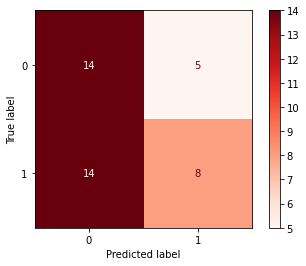

In [375]:
# 混同行列を表示
cm = confusion_matrix(y_val_new, pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)